In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from neighborhoods import nearest_neighborhood
from datetime import date
from dateutil.relativedelta import relativedelta



In [2]:
df = pd.read_csv('eviction_notices.csv', parse_dates=['File Date'], encoding = "ISO-8859-1")

/Users/jakram/anaconda/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2717: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
len(df)

37736

In [4]:
df.head()

,Eviction ID,Address,City,State,Eviction Notice Source Zipcode,File Date,Non Payment,Breach,Nuisance,Illegal Use,...,Roommate Same Unit,Other Cause,Late Payments,Lead Remediation,Development,Good Samaritan Ends,Constraints Date,Supervisor District,Neighborhoods - Analysis Boundaries,Location
0,M161957,300 Block Of Park Street,San Francisco,CA,94110,2016-06-06,False,False,False,False,...,False,False,False,False,False,False,NaN,9.0,Bernal Heights,"(37.7364374645373, -122.417989910582)"
1,M162256,200 Block Of Seneca Avenue,San Francisco,CA,94112,2016-06-29,False,False,False,False,...,False,False,False,False,False,False,8/25/2021,11.0,Outer Mission,"(37.7205429316262, -122.443264852669)"
2,M162135,200 Block Of Dolores Street,San Francisco,CA,94103,2016-06-28,False,True,False,False,...,False,False,False,False,False,False,NaN,8.0,Castro/Upper Market,"(37.7652067507312, -122.426591617441)"
3,M161901,1200 Block Of 9th Avenue,San Francisco,CA,94122,2016-06-02,False,False,False,False,...,False,False,False,False,False,False,NaN,5.0,Inner Sunset,"(37.764977785911, -122.4664456379)"
4,M162428,1400 Block Of Larkin Street,San Francisco,CA,94109,2016-02-28,False,False,False,False,...,False,False,False,False,False,False,NaN,3.0,Nob Hill,"(37.7912373166567, -122.419197310472)"


In [5]:
# Dump all rows with no file date (eviction date) or location data (lat, lng).
df = df.dropna(subset=['Location','File Date'])
len(df)

36289

In [6]:
mindate = date(2007, 9, 15) # This is the minimum date for which we have home values from Zillow.

# This is the number of lookback months to find change in home values prior to an eviction.
lookbackperiod_mos = 36 

# Trimming the dataset to remove very early values that would not return values in the lookback period.
df = df[df['File Date'] > (mindate + relativedelta(months=+lookbackperiod_mos)) ]
len(df)

11986

In [7]:
# This is the start date: the date after which evicitons are included in the analysis, used for correct labeling.
startdate = mindate + relativedelta(months=+lookbackperiod_mos)
startdate = date.strftime(startdate,"%b %Y")
startdate

'Sep 2010'

In [8]:
# These are the column names for evictions that are non-cause:
non_cause_eviction_names = ['Owner Move In',
                            'Condo Conversion',
                            'Ellis Act WithDrawal',
                            'Substantial Rehab',
                            'Development',
                            'Demolition',
                            'Capital Improvement',
                            'Substantial Rehab'
                           ]

In [9]:
# Function appends data from Zillow API and data file using neighborhood()  
def addPricingData_lookback(row, lookback):
    latlng = row['Location']
    lat, lng = latlng.split(',')
    lat = float(lat.replace('(','')) # Reformat lat, lng to separate arguments.
    lng = float(lng.replace(')',''))
    evictdate = row['File Date'].date() # Convert eviction date and create date keys for eviciton date and starting valuation date. 
    startdate = evictdate + relativedelta(months=-lookback)
    evictdate_key = date.strftime(evictdate,"%b%Y")
    evictdateyear = date.strftime(evictdate,"%Y")
    startdate_key = date.strftime(startdate, "%b%Y")
    neighborhood = nearest_neighborhood(lat, lng) # Create neighborhood object for lat, lng.
    name = neighborhood.name
    meanvalue = float(neighborhood.meanvalue)
    evictdatevalue = neighborhood.prices[evictdate_key]
    s = neighborhood.prices[startdate_key]
    c = neighborhood.prices[evictdate_key]
    valueincrease = (c - s)/s
    return pd.Series({'Eviction_id':row['Eviction ID'],'Lat': lat, 'Lng': lng, 'Year': evictdateyear, 'Zillow_Neighborhood':name, 'Z_2017_Value':meanvalue, 'Z_Evict_Date_Value':evictdatevalue, 'Z_Value_Increase':valueincrease}) 
    return name

In [10]:
# This dictionary can be used to count each type of eviciton during an aggregation.
baseaggregation = {
    'Owner Move In' : {
        'total_move_in' : 'sum'
    },
    'Condo Conversion' : {
         'total_condo' : 'sum'
    },
    'Ellis Act WithDrawal' : {
         'total_ellis' : 'sum'
    },
    'Development' : {
         'total_development' : 'sum'
    },
    'Demolition' : {
         'total_demolition' : 'sum'
    },
    'Capital Improvement' : {
         'total_capital_improvement' : 'sum'
    },
    'Substantial Rehab' : {
         'total_substantial_rehab' : 'sum'
    },
    'Non Payment' : {
         'total_non_payment' : 'sum'
    },
    'Breach' : {
         'total_breach' : 'sum'
    },
    'Nuisance' : {
         'total_nuisance' : 'sum'
    },
    'Illegal Use' : {
         'total_illegal_use' : 'sum'
    },
    'Failure to Sign Renewal' : {
         'total_non_renewal' : 'sum'
    },
    'Access Denial' : {
         'total_access_denial' : 'sum'
    },
    'Unapproved Subtenant' : {
         'total_unapproved_subtenant' : 'sum'
    },
    'Roommate Same Unit' : {
         'total_roommate' : 'sum'
    },
    'Other Cause' : {
         'total_other_cause' : 'sum'
    },
    'Late Payments' : {
         'total_late_payment' : 'sum'
    },
    'Good Samaritan Ends' : {
         'total_total_good_samaritan' : 'sum'
    },
    'Eviction ID' : {
        'total_evictions' : 'count'
    },
    'Z_2017_Value' : {
        'current_value' : 'mean'
    },
    'Z_Evict_Date_Value' :{ 
        'eviction_date_value' : 'mean'
    }
}

In [11]:
# Merge the results of our calls to neighborhood() back to our dataframe.
allevictions = df.merge(df.apply(lambda row: addPricingData_lookback(row, lookbackperiod_mos), axis = 1), left_on='Eviction ID', right_on='Eviction_id')
allevictions.head()

,Eviction ID,Address,City,State,Eviction Notice Source Zipcode,File Date,Non Payment,Breach,Nuisance,Illegal Use,...,Neighborhoods - Analysis Boundaries,Location,Eviction_id,Lat,Lng,Year,Z_2017_Value,Z_Evict_Date_Value,Z_Value_Increase,Zillow_Neighborhood
0,M161957,300 Block Of Park Street,San Francisco,CA,94110,2016-06-06,False,False,False,False,...,Bernal Heights,"(37.7364374645373, -122.417989910582)",M161957,37.736437,-122.417990,2016,1083700.0,1193000.0,0.404025,Bernal Heights
1,M162256,200 Block Of Seneca Avenue,San Francisco,CA,94112,2016-06-29,False,False,False,False,...,Outer Mission,"(37.7205429316262, -122.443264852669)",M162256,37.720543,-122.443265,2016,814200.0,951300.0,0.341371,Mission Terrace
2,M162135,200 Block Of Dolores Street,San Francisco,CA,94103,2016-06-28,False,True,False,False,...,Castro/Upper Market,"(37.7652067507312, -122.426591617441)",M162135,37.765207,-122.426592,2016,0.0,NaN,NaN,Duboce Triangle
3,M161901,1200 Block Of 9th Avenue,San Francisco,CA,94122,2016-06-02,False,False,False,False,...,Inner Sunset,"(37.764977785911, -122.4664456379)",M161901,37.764978,-122.466446,2016,1154400.0,1362400.0,0.446899,Inner Sunset
4,M162428,1400 Block Of Larkin Street,San Francisco,CA,94109,2016-02-28,False,False,False,False,...,Nob Hill,"(37.7912373166567, -122.419197310472)",M162428,37.791237,-122.419197,2016,1192900.0,1461900.0,0.434079,Nob Hill


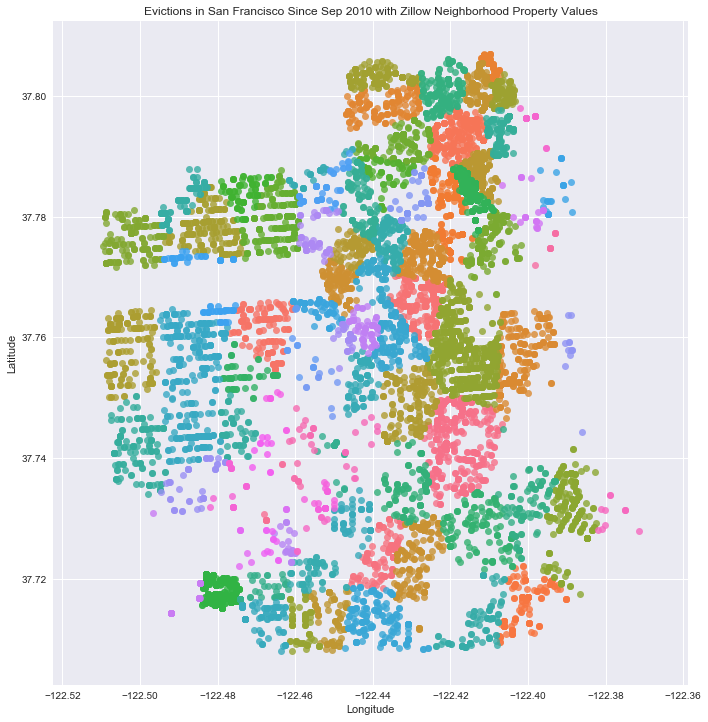

In [12]:
ax = sns.lmplot(x='Lng', y='Lat', hue='Zillow_Neighborhood', size=10, data=allevictions, fit_reg=False, legend=False)
ax.despine(left=True)

# Set title, x-axis label, y-axis label.
plt.title('Evictions in San Francisco Since %s with Zillow Neighborhood Property Values' % startdate)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

In [13]:
# Adding a key value pair for the zillow value increase for our lookback function. 
aggregation_lookback = dict(baseaggregation)
aggregation_lookback.update({ 'Z_Value_Increase' : {'average_value_increase' : 'mean'},})

# Creating a dataframe to group by neighborhood. 
groupby_hood = allevictions.groupby([('Zillow_Neighborhood')],as_index=True).agg(aggregation_lookback).reset_index()

groupby_hood.columns = groupby_hood.columns.droplevel(level=1)


# Creating a row-wise sum of all the non-cause eviciton counts.
groupby_hood['total_non_cause'] = groupby_hood[non_cause_eviction_names].sum(axis=1)

# Adding a column to show the frequency of non-cause evicitons.
groupby_hood['non_cause_frequency'] = (groupby_hood['total_non_cause']/
                                                               groupby_hood['Eviction ID']
                                                              )

# Drop rows for neighborhoods without pricing data.
groupby_hood_pricing = groupby_hood.dropna(subset=['Z_Value_Increase']).reset_index()



# Drop neighborhoods with small sample sizes.
plot_non_cause_frequency = groupby_hood_pricing[groupby_hood_pricing['Eviction ID'] > 40]

plot_non_cause_frequency.head()


,index,Zillow_Neighborhood,Owner Move In,Condo Conversion,Ellis Act WithDrawal,Development,Demolition,Capital Improvement,Substantial Rehab,Non Payment,...,Roommate Same Unit,Other Cause,Late Payments,Good Samaritan Ends,Eviction ID,Z_2017_Value,Z_Evict_Date_Value,Z_Value_Increase,total_non_cause,non_cause_frequency
0,3,Bayview,30.0,0.0,6.0,0.0,3.0,1.0,0.0,44.0,...,14.0,19.0,17.0,0.0,253,612400.0,6.249269e+05,0.603670,40.0,0.158103
1,4,Bernal Heights,97.0,7.0,63.0,1.0,15.0,7.0,6.0,18.0,...,31.0,7.0,11.0,3.0,405,1083700.0,1.003395e+06,0.310101,202.0,0.498765
2,5,Buena Vista Park,10.0,0.0,14.0,0.0,3.0,9.0,0.0,5.0,...,5.0,3.0,5.0,0.0,105,1304100.0,1.166338e+06,0.206609,36.0,0.342857
3,6,Central Richmond,63.0,2.0,25.0,0.0,6.0,4.0,0.0,11.0,...,6.0,8.0,15.0,0.0,246,1284800.0,1.209454e+06,0.371184,100.0,0.406504
4,7,Central Sunset,71.0,0.0,22.0,0.0,10.0,3.0,0.0,9.0,...,4.0,9.0,8.0,0.0,199,994300.0,9.901045e+05,0.278960,106.0,0.532663


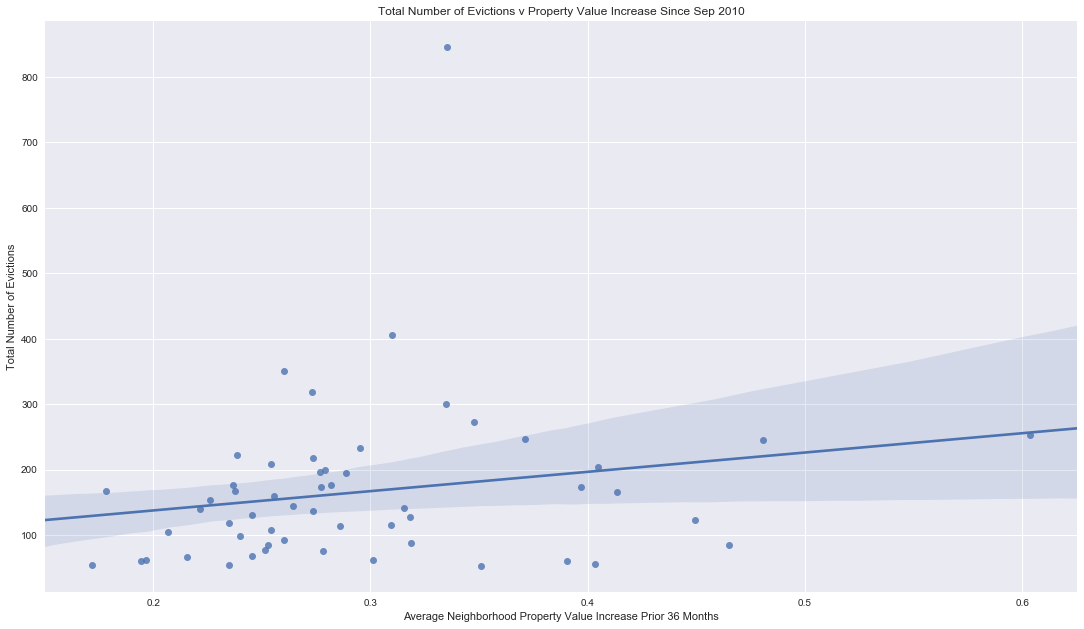

In [14]:
fig, ax = plt.subplots()
fig.set_size_inches(18.5, 10.5)
ax = sns.regplot(y='Eviction ID', x='Z_Value_Increase', data=plot_non_cause_frequency)
plt.title('Total Number of Evictions v Property Value Increase Since %s' % startdate)
plt.ylabel('Total Number of Evictions')
plt.xlabel('Average Neighborhood Property Value Increase Prior %s Months' % lookbackperiod_mos)
plt.show()

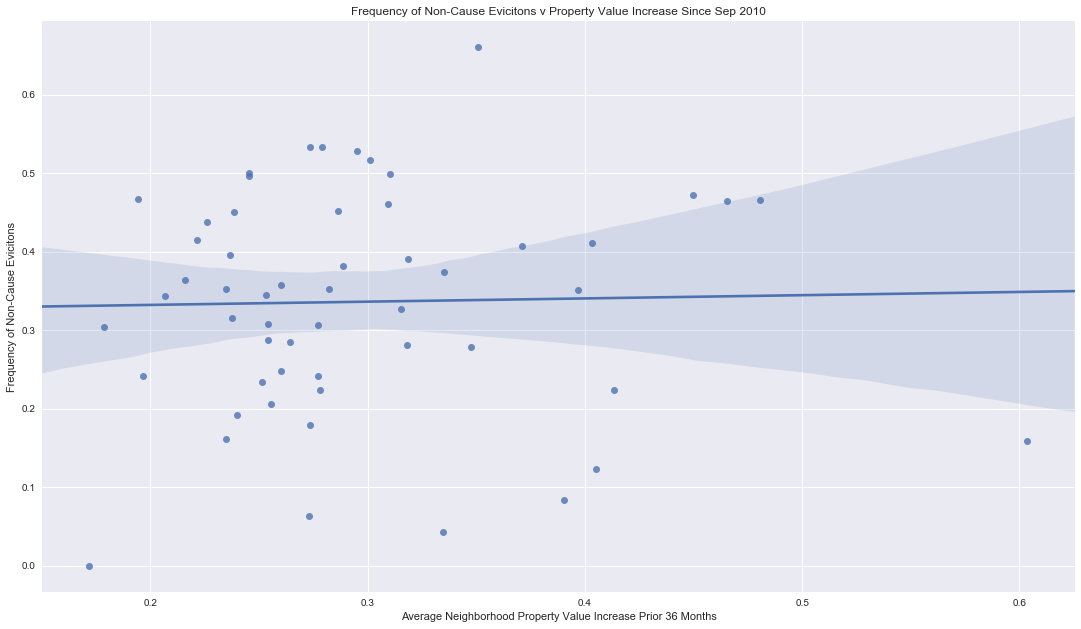

In [15]:
fig, ax = plt.subplots()
fig.set_size_inches(18.5, 10.5)
ax = sns.regplot(y='non_cause_frequency', x='Z_Value_Increase', data=plot_non_cause_frequency)
plt.title('Frequency of Non-Cause Evicitons v Property Value Increase Since %s' % startdate)
plt.ylabel('Frequency of Non-Cause Evicitons')
plt.xlabel('Average Neighborhood Property Value Increase Prior %s Months' % lookbackperiod_mos)
plt.show()

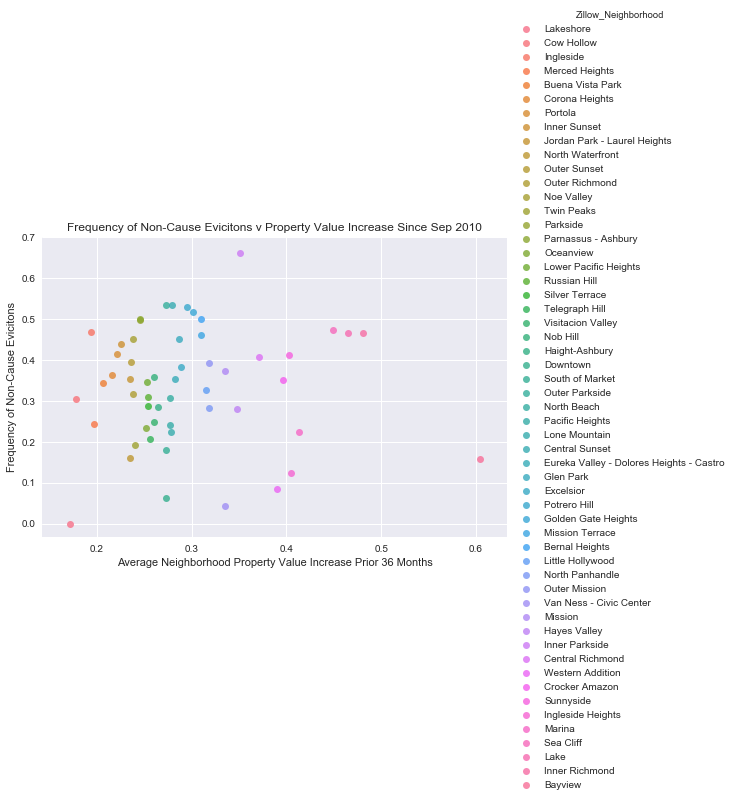

In [16]:
lmplot_non_cause_frequency = plot_non_cause_frequency.sort_values(by=('Z_Value_Increase'))

sns.set(style="darkgrid")

# Set style of scatterplot

# Set markers
# markers = ['o','_','x']*18

# Create scatterplot of non-cause eviciton frequency with property value increase.
ax = sns.lmplot('Z_Value_Increase', # Horizontal axis
                'non_cause_frequency', # Vertical axis
                data = lmplot_non_cause_frequency, # Data source
                fit_reg = False, # Don't fix a regression line
                hue = 'Zillow_Neighborhood', # Set color
#                 markers = markers
                aspect=1.5
          )

# Set title, x-axis label, y-axis label.
plt.title('Frequency of Non-Cause Evicitons v Property Value Increase Since %s' % startdate)
plt.ylabel('Frequency of Non-Cause Evicitons')
plt.xlabel('Average Neighborhood Property Value Increase Prior %s Months' % lookbackperiod_mos)
plt.show()

In [17]:
groupby_hood.head()

,Zillow_Neighborhood,Owner Move In,Condo Conversion,Ellis Act WithDrawal,Development,Demolition,Capital Improvement,Substantial Rehab,Non Payment,Breach,...,Roommate Same Unit,Other Cause,Late Payments,Good Samaritan Ends,Eviction ID,Z_2017_Value,Z_Evict_Date_Value,Z_Value_Increase,total_non_cause,non_cause_frequency
0,Alamo Square,20.0,2.0,16.0,0.0,1.0,1.0,1.0,14.0,42.0,...,3.0,1.0,12.0,0.0,154,0.0,NaN,NaN,42.0,0.272727
1,Anza Vista,34.0,1.0,6.0,0.0,0.0,14.0,0.0,8.0,28.0,...,5.0,4.0,21.0,0.0,142,0.0,NaN,NaN,55.0,0.387324
2,Balboa Terrace,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,...,2.0,1.0,0.0,0.0,6,0.0,NaN,NaN,0.0,0.000000
3,Bayview,30.0,0.0,6.0,0.0,3.0,1.0,0.0,44.0,68.0,...,14.0,19.0,17.0,0.0,253,612400.0,6.249269e+05,0.603670,40.0,0.158103
4,Bernal Heights,97.0,7.0,63.0,1.0,15.0,7.0,6.0,18.0,87.0,...,31.0,7.0,11.0,3.0,405,1083700.0,1.003395e+06,0.310101,202.0,0.498765


In [18]:
eviction_types = groupby_hood.drop(['Eviction ID',
                                    'Z_2017_Value',
                                    'Z_Evict_Date_Value',
                                    'Z_Value_Increase',
                                    'total_non_cause',
                                    'non_cause_frequency',
                                    'Zillow_Neighborhood'
                                   ],
                                   axis=1
                                  )

def kind(row):
   if row['index'] in non_cause_eviction_names:
      return 'Non-Cause'
   else:
      return 'Cause'

eviction_types = eviction_types.transpose().reset_index()
eviction_types['Total'] = eviction_types.sum(axis=1)
eviction_types['Category'] = eviction_types.apply (lambda row: kind(row),axis=1)
eviction_types.head()

,index,0,1,2,3,4,5,6,7,8,...,80,81,82,83,84,85,86,87,Total,Category
0,Owner Move In,20.0,34.0,0.0,30.0,97.0,10.0,63.0,71.0,4.0,...,18.0,2.0,20.0,7.0,3.0,7.0,2.0,1.0,1905.0,Non-Cause
1,Condo Conversion,2.0,1.0,0.0,0.0,7.0,0.0,2.0,0.0,1.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,61.0,Non-Cause
2,Ellis Act WithDrawal,16.0,6.0,0.0,6.0,63.0,14.0,25.0,22.0,0.0,...,0.0,7.0,2.0,1.0,0.0,0.0,0.0,0.0,879.0,Non-Cause
3,Development,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,340.0,Non-Cause
4,Demolition,1.0,0.0,0.0,3.0,15.0,3.0,6.0,10.0,1.0,...,1.0,0.0,1.0,0.0,1.0,2.0,3.0,0.0,338.0,Non-Cause


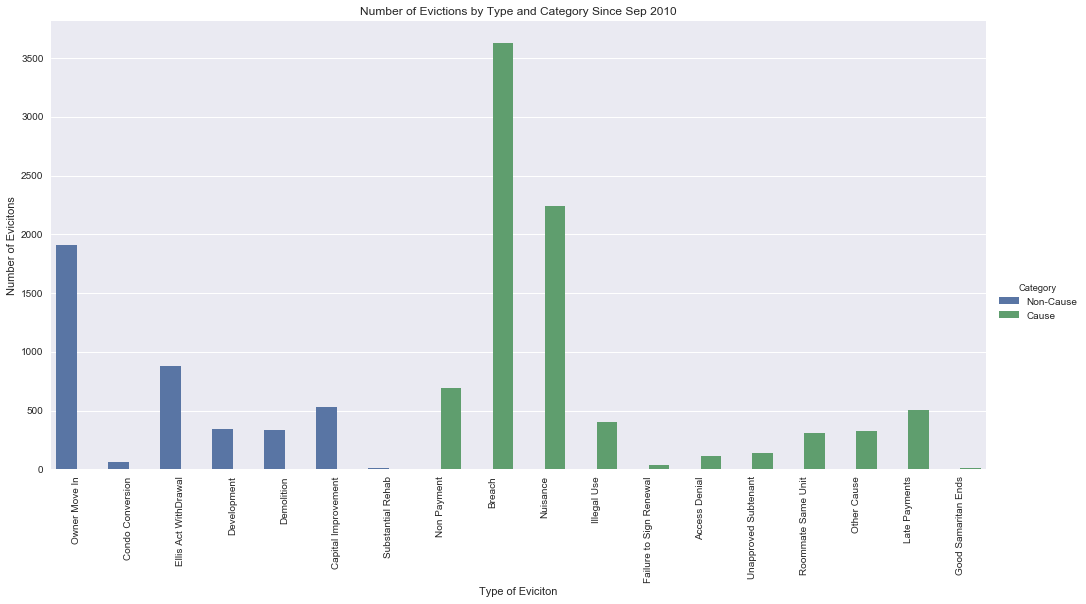

In [19]:

ax1 = sns.factorplot(x='index', y='Total', hue='Category', data=eviction_types, kind='bar', size=7, aspect=2)
ax1.set_xticklabels(rotation=90)
plt.title('Number of Evictions by Type and Category Since %s' % startdate)
plt.ylabel('Number of Evicitons')
plt.xlabel('Type of Eviciton')
plt.show()

In [20]:
pivot = pd.pivot_table(groupby_hood,index=["Zillow_Neighborhood"]).reset_index()
pivot

,Zillow_Neighborhood,Access Denial,Breach,Capital Improvement,Condo Conversion,Demolition,Development,Ellis Act WithDrawal,Eviction ID,Failure to Sign Renewal,...,Other Cause,Owner Move In,Roommate Same Unit,Substantial Rehab,Unapproved Subtenant,Z_2017_Value,Z_Evict_Date_Value,Z_Value_Increase,non_cause_frequency,total_non_cause
0,Alamo Square,1.0,42.0,1.0,2.0,1.0,0.0,16.0,154,3.0,...,1.0,20.0,3.0,1.0,2.0,0.0,NaN,NaN,0.272727,42.0
1,Anza Vista,3.0,28.0,14.0,1.0,0.0,0.0,6.0,142,0.0,...,4.0,34.0,5.0,0.0,3.0,0.0,NaN,NaN,0.387324,55.0
2,Balboa Terrace,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6,0.0,...,1.0,0.0,2.0,0.0,0.0,0.0,NaN,NaN,0.000000,0.0
3,Bayview,10.0,68.0,1.0,0.0,3.0,0.0,6.0,253,3.0,...,19.0,30.0,14.0,0.0,0.0,612400.0,6.249269e+05,0.603670,0.158103,40.0
4,Bernal Heights,4.0,87.0,7.0,7.0,15.0,1.0,63.0,405,0.0,...,7.0,97.0,31.0,6.0,2.0,1083700.0,1.003395e+06,0.310101,0.498765,202.0
5,Buena Vista Park,3.0,20.0,9.0,0.0,3.0,0.0,14.0,105,2.0,...,3.0,10.0,5.0,0.0,3.0,1304100.0,1.166338e+06,0.206609,0.342857,36.0
6,Central Richmond,3.0,66.0,4.0,2.0,6.0,0.0,25.0,246,0.0,...,8.0,63.0,6.0,0.0,3.0,1284800.0,1.209454e+06,0.371184,0.406504,100.0
7,Central Sunset,2.0,25.0,3.0,0.0,10.0,0.0,22.0,199,0.0,...,9.0,71.0,4.0,0.0,0.0,994300.0,9.901045e+05,0.278960,0.532663,106.0
8,Central Waterfront - Dogpatch,0.0,2.0,0.0,1.0,1.0,0.0,0.0,12,0.0,...,2.0,4.0,0.0,0.0,0.0,986300.0,8.528000e+05,0.202854,0.500000,6.0
9,Chinatown,2.0,52.0,31.0,0.0,0.0,0.0,5.0,164,0.0,...,4.0,5.0,0.0,0.0,13.0,0.0,NaN,NaN,0.250000,41.0


In [21]:
# Creating a dataframe to group by year, then neighborhood. 
groupby_month = allevictions
groupby_month['datetime'] = pd.to_datetime(groupby_month['File Date'])
groupby_month.index = groupby_month['datetime']

groupby_month = groupby_month.resample('M').agg(baseaggregation)
groupby_month.columns = groupby_month.columns.droplevel(level=1)

groupby_month['total_non_cause'] = groupby_month[non_cause_eviction_names].sum(axis=1)
groupby_month

,Owner Move In,Condo Conversion,Ellis Act WithDrawal,Development,Demolition,Capital Improvement,Substantial Rehab,Non Payment,Breach,Nuisance,...,Access Denial,Unapproved Subtenant,Roommate Same Unit,Other Cause,Late Payments,Good Samaritan Ends,Eviction ID,Z_2017_Value,Z_Evict_Date_Value,total_non_cause
datetime,,,,,,,,,,,,,,,,,,,,,
2010-09-30,5.0,0.0,0.0,106.0,1.0,0.0,0.0,4.0,19.0,4.0,...,0.0,1.0,1.0,3.0,1.0,0.0,147,2.034497e+05,7.223250e+05,112.0
2010-10-31,9.0,0.0,4.0,0.0,1.0,0.0,0.0,9.0,48.0,30.0,...,2.0,1.0,6.0,7.0,3.0,0.0,120,7.843950e+05,7.721928e+05,14.0
2010-11-30,9.0,0.0,2.0,0.0,2.0,1.0,0.0,8.0,27.0,21.0,...,1.0,1.0,4.0,3.0,8.0,0.0,96,1.003168e+06,8.124325e+05,14.0
2010-12-31,2.0,1.0,0.0,0.0,3.0,1.0,0.0,6.0,16.0,11.0,...,3.0,0.0,1.0,2.0,1.0,0.0,45,8.597333e+05,7.716794e+05,7.0
2011-01-31,8.0,0.0,0.0,0.0,1.0,2.0,0.0,14.0,17.0,24.0,...,1.0,2.0,3.0,3.0,3.0,0.0,77,9.253883e+05,7.266508e+05,11.0
2011-02-28,10.0,0.0,7.0,0.0,3.0,7.0,1.0,8.0,24.0,15.0,...,1.0,0.0,4.0,9.0,4.0,0.0,94,1.030012e+06,7.724651e+05,29.0
2011-03-31,11.0,1.0,2.0,0.0,1.0,3.0,0.0,13.0,25.0,25.0,...,6.0,3.0,4.0,6.0,3.0,0.0,102,9.375598e+05,7.394716e+05,18.0
2011-04-30,9.0,0.0,1.0,0.0,2.0,2.0,0.0,5.0,23.0,17.0,...,1.0,0.0,1.0,1.0,2.0,0.0,59,1.055266e+06,7.510278e+05,14.0
2011-05-31,15.0,0.0,3.0,0.0,5.0,4.0,0.0,8.0,65.0,22.0,...,2.0,1.0,0.0,3.0,2.0,0.0,130,5.998731e+05,6.845338e+05,27.0


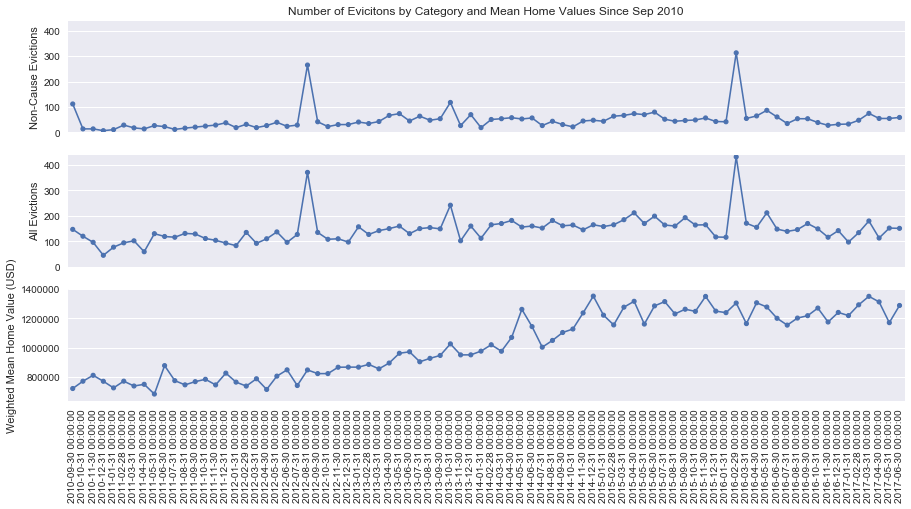

In [22]:
f, axes = plt.subplots(3, 1, figsize=(15, 7), sharex=True, sharey=False)


axes[0] = sns.pointplot(x=groupby_month.index, y=groupby_month['total_non_cause'], data=groupby_month, scale=0.5, ax=axes[0])
axes[1] = sns.pointplot(x=groupby_month.index, y=groupby_month['Eviction ID'], data=groupby_month, scale=0.5, ax=axes[1])
axes[2] = sns.pointplot(x=groupby_month.index, y=groupby_month['Z_Evict_Date_Value'], data=groupby_month, scale=0.5, ax=axes[2])

axes[0].set_xlabel('')
axes[1].set_xlabel('')
axes[2].set_xlabel('')

axes[0].set_ylabel('Non-Cause Evictions')
axes[1].set_ylabel('All Evictions')
axes[2].set_ylabel('Weighted Mean Home Value (USD)')

axes[0].set_ylim([0, 440])
axes[1].set_ylim([0, 440])

axes[0].set_title('Number of Evicitons by Category and Mean Home Values Since %s' % startdate)
axes[2].set_xticklabels(labels=groupby_month.index, rotation=90)

plt.show()